In [1]:
import os

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

In [122]:
proxy='http://127.0.0.1:7890'
os.environ['HTTP_PROXY']=proxy
os.environ['HTTPS_PROXY']=proxy

Fetching data for AAPL...
=== Unified grid analysis (Symbol=AAPL) ===
Short=[5, 10, 15, 20], Long=[30, 50, 60, 80, 100]
Buy=[1.0], Sell=[1.0], Exclusives=[False]
Cooldown=0, Exec=open@delay=1, Fractional=True
All unified-grid comparisons saved at: results/parameter_comparison/AAPL_grid_comparison.csv
=== Top5 by annualized_return ===
    short_window  long_window  buy_fraction  sell_fraction  exclusive  \
17            20           60           1.0            1.0      False   
3              5           80           1.0            1.0      False   
8             10           80           1.0            1.0      False   
7             10           60           1.0            1.0      False   
12            15           60           1.0            1.0      False   

    annualized_return  max_drawdown  sharpe_ratio  win_rate  num_trades  \
17              18.37        -16.27          1.02     54.55          11   
3               17.14        -19.18          0.94     42.11          19   


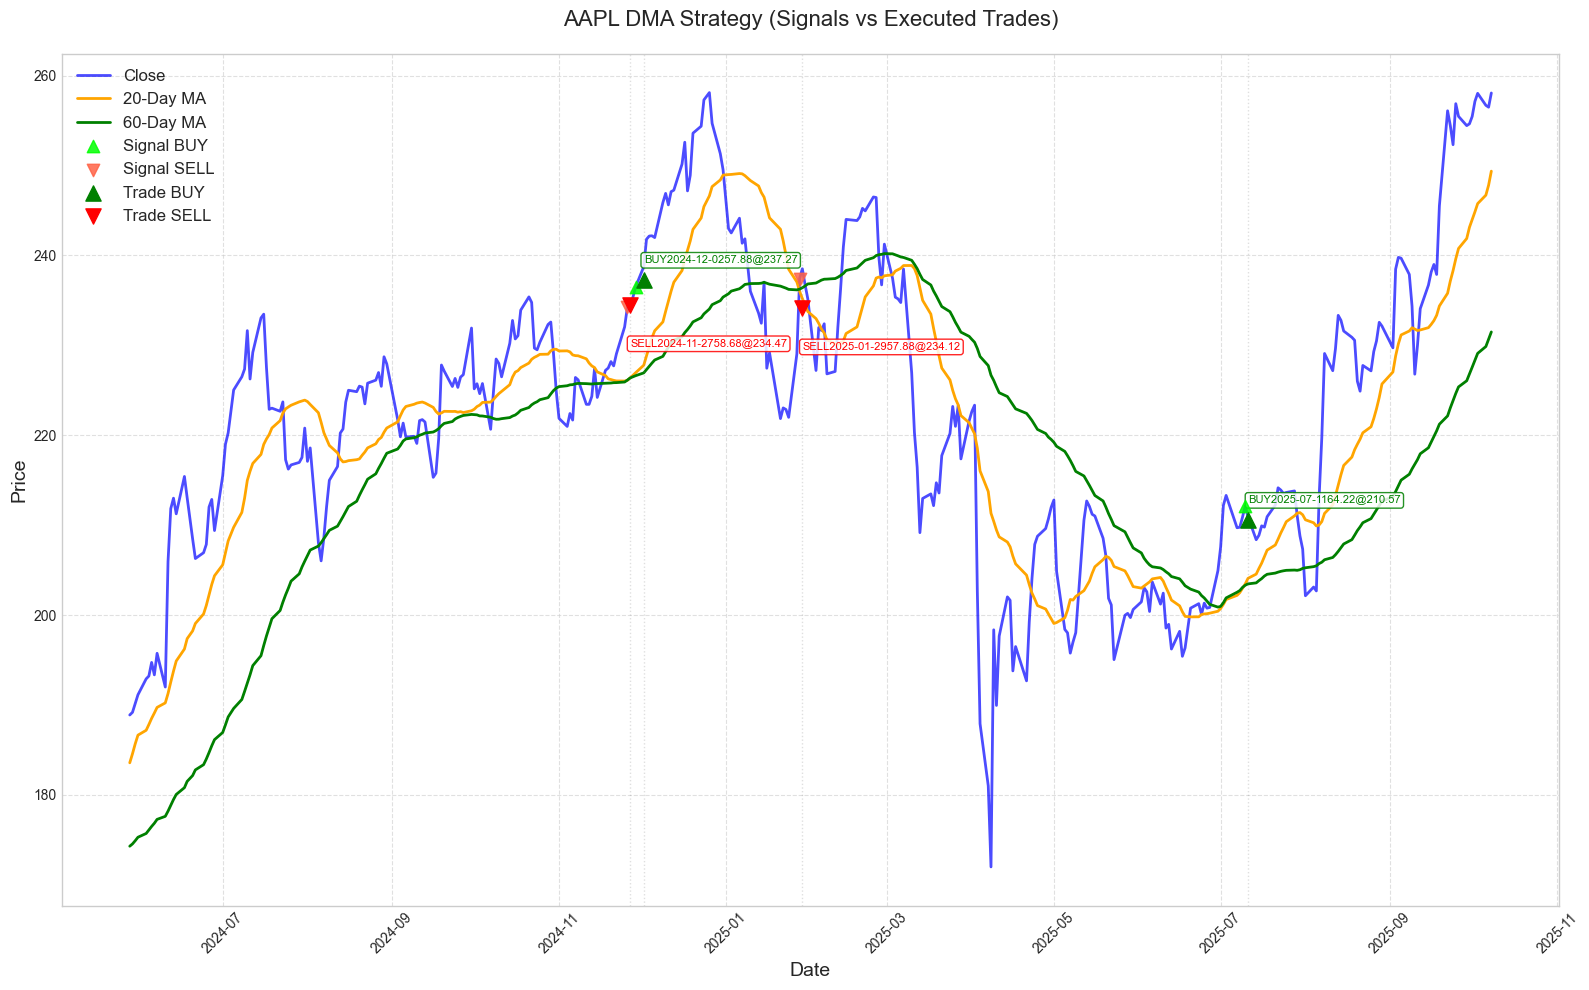

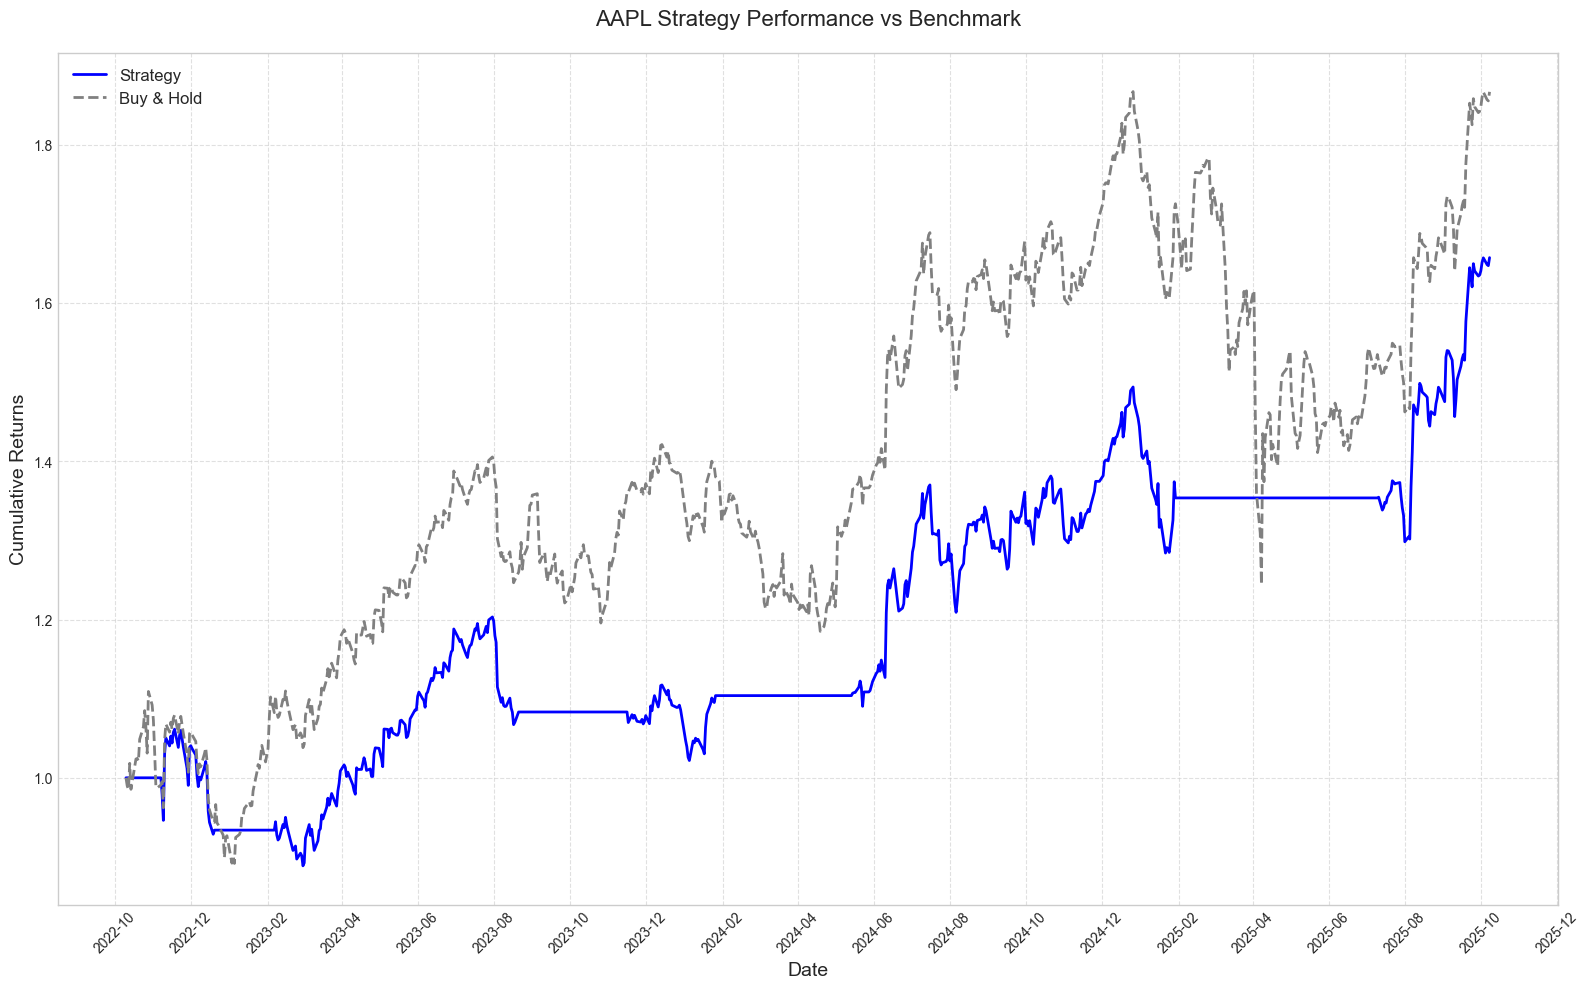

In [2]:
from data import fetch_stock_data
from analysis import analyze_grid

SYMBOL = "AAPL"
INITIAL_CAPITAL = 10000.0
TRANSACTION_COST = 0.001
COOLDOWN_BARS = 0
TEST_SHORT_WINDOWS = [5, 10, 15, 20]
TEST_LONG_WINDOWS  = [30, 50, 60, 80, 100]
BUY_GRID  = [ 1.0]
SELL_GRID = [1.0]
EXCLUSIVES = [False]
LAST_N_DAYS = 500

print(f"Fetching data for {SYMBOL}...")
stock_data = fetch_stock_data(SYMBOL, period='3y')

metrics_comparison, top5, best_metrics, best_bt_res, best_df_sig = analyze_grid(
    stock_data=stock_data,
    symbol=SYMBOL,
    short_windows=TEST_SHORT_WINDOWS,
    long_windows=TEST_LONG_WINDOWS,
    buy_fractions=BUY_GRID,
    sell_fractions=SELL_GRID,
    exclusives=EXCLUSIVES,
    cooldown_bars=COOLDOWN_BARS,
    initial_capital=INITIAL_CAPITAL,
    transaction_cost=TRANSACTION_COST,
    exec_price='open',
    exec_delay_bars=1,
    allow_fractional=True,
    last_n_days=LAST_N_DAYS,
    save_comparison=True,
    save_individual=False,
    top_k=5,
    ranking_metric='annualized_return',
    results_root='results'
)
